# Preprocessing + Feature Engineering + Model

This notebook contains preprocessing of the Customer Accounts data, feature engineering of the fields and experimentation with different machine learning models and techniques. The purpose is to build a model which can predict the accounts a customer would acquire based on the past customer history.

### Installing required libraries

In [2]:
import sys
!{sys.executable} -m pip install scikit-multilearn

  Using cached https://files.pythonhosted.org/packages/bb/1f/e6ff649c72a1cdf2c7a1d31eb21705110ce1c5d3e7e26b2cc300e1637272/scikit_multilearn-0.2.0-py3-none-any.whl


In [3]:
!{sys.executable} -m pip install xgboost

  Using cached https://files.pythonhosted.org/packages/4f/4c/4969b10939c4557ae46e5569d07c0c7ce772b3d6b9c1401a6ed07059fdee/xgboost-0.81.tar.gz
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /Users/Mehvish/Library/Caches/pip/wheels/8a/89/0c/4870bb69132698f40889fa956f92e630a36c1fd7173fcc759f
Successfully built xgboost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import Imputer, LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, average_precision_score
from collections import defaultdict

### Class for implementing Label Encoder for multiple columns

This class implements the functionality of a label encoder for multiple columns.
Reference: https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d


In [30]:

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [2]:
# loading training data
train_accounts = pd.read_csv("data_csv/train/train_accounts.csv")
monthly_info = pd.read_csv("data_csv/train/train_monthly_info.csv")
xref = pd.read_csv("data_csv/train/xref.csv")
test_df = pd.read_csv("data_csv/test/test_monthly_info.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Undersampling 

As discovered during EDA, there's a class imbalance in the dataset (current_accounts has a lot more customers than any other account), so inorder to deal with that, the data from class current_accounts was undersampled.

In [75]:
def under_sample_data(X_train, train_acc, sampling_ratio=0.8):
        curr_acc = train_acc[(train_acc["current_accounts"] == 1) & (train_acc["guarantees"] == 0) 
                         & (train_acc["savings_account"] == 0) & (train_acc["derived_account"] == 0) 
                         & (train_acc["particular_account"] == 0) & (train_acc["particular_plus_account"] == 0) 
                         & (train_acc["short_term_deposits"] == 0) & (train_acc["medium_term_deposits"] == 0) 
                         & (train_acc["long_term_deposits"] == 0) & (train_acc["e_account"] == 0) 
                         & (train_acc["funds"] == 0) & (train_acc["mortgage"] == 0) 
                         & (train_acc["pensions"] == 0) & (train_acc["loans"] == 0) & (train_acc["taxes"] == 0) 
                         & (train_acc["credit_card"] == 0) & (train_acc["securities"] == 0) 
                         & (train_acc["home_account"] == 0) & (train_acc["payroll"] == 0) 
                         & (train_acc["direct_debt"] == 0)]
        
        # sampling to remove 70%
        curr_acc = curr_acc.sample(frac=sampling_ratio, random_state=1)
        
        # select only those which are NOT in curr_acc, i.e. the remaining 30%
        train_acc = train_acc[~train_acc.isin(curr_acc)].dropna()
        
        # join with X_train to get the rows
        sampled_X = pd.merge(X_train, train_acc, how="inner",  on=["date", "cust_key"])
        
        labels = list(train_acc.columns)
        labels.remove("date")
        labels.remove("cust_key")
    
        sampled_y_train = sampled_X[labels]
        sampled_X_train = sampled_X.drop(labels, axis=1)
        
        return sampled_X_train, sampled_y_train


### Preprocessing the data: 

Dropping spouse_index and last_date_primary because 99% of the fields were empty; dropping province_name because it has one to one mapping with province_code, so redundant feature; dropping primary address because it just has '1' so might not be that informative.

There were inconsistent values in "age", "seniority" and "customer_type", so in order to make them consistent, typecasting them to the same type.

In [3]:
def preprocess(monthly_info_df, testing=False):
        
    monthly_info_df = monthly_info_df.drop((["spouse_index", "last_date_primary", 
                                             "province_name", "primary_address", "open_date"]), axis=1)

        
    monthly_info_df["age"] = monthly_info_df["age"].astype(np.int)
    monthly_info_df["seniority"] = monthly_info_df["seniority"].astype(np.int)
    monthly_info_df["customer_type"] = monthly_info_df["customer_type"].astype(np.str)
    
    return monthly_info_df
    

In order to make sure that there was one to one mapping between the train accounts and monthly info, the dataframes were joined on the common customer keys and date and then the final dataframe was divided into train data (X_train) and train labels (y_train). The following function implements the above mentioned functionality.

In [56]:

def prepare_train_set(train_accounts, monthly_info, xref):
    combined_df = pd.merge(train_accounts, xref, how="inner", on="cust_key")
    full_train_set = pd.merge(combined_df, monthly_info, how="inner", on=["date", "cust_id"])
    
    # cleaning the data to remove noise
    full_train_set = full_train_set[full_train_set.seniority != '-999999'] 
    full_train_set = full_train_set[full_train_set.seniority != '     NA']
    full_train_set = full_train_set[full_train_set.age != ' NA']
    
    labels = list(train_accounts.columns)
    
    y_train = full_train_set[labels]
    
    labels.remove("date")
    labels.remove("cust_key")
    X_train = full_train_set.drop(labels, axis=1)
                              
    return X_train, y_train

The following function is used to fill the missing values in the data. If the column type is categorical, it fills the missing value with the most frequent value of the column. Otherwise, it takes an average of the column and fills the missing spots with it.

In [5]:
def fill_missing_values(customer_info_df, categorical, numerical):
    for feat in categorical:
        customer_info_df[feat].fillna(customer_info_df[feat].mode()[0], inplace=True)
    
    imputer = Imputer(missing_values=np.nan, strategy='mean', axis=1)
    for feat in numerical:
        customer_info_df[feat] = imputer.fit_transform([customer_info_df[feat]]).T

In [57]:
X_train, y_train = prepare_train_set(train_accounts, monthly_info, xref)

In [61]:
X_train = preprocess(X_train)

In [10]:
categorical_feats = ["segment", "employee_index", "channel", "country", "sex",
                    "last_6_months_flag", "primary", "customer_type", "customer_relation",
                     "domestic_index", "foreigner_index", "deceased_status",
                     "province_code", "activity_index"]
numerical_feats = ["age", "seniority", "gross_income"]

In [62]:
fill_missing_values(X_train, categorical_feats, numerical_feats)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [63]:
# making a copy so the original DF doesn't get affected.

X_train_encode = X_train.copy()

In [64]:
X_train_encode = X_train_encode.drop(['date', 'cust_key', 'cust_id'], axis=1)

In [65]:
X_test = preprocess(test_df, testing=True)

In [66]:
fill_missing_values(X_test, categorical_feats, numerical_feats)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [67]:
X_test = X_test.drop(['date', 'cust_id'], axis=1)

In [68]:
X_train_encode.columns

Index(['employee_index', 'country', 'sex', 'age', 'last_6_months_flag',
       'seniority', 'primary', 'customer_type', 'customer_relation',
       'domestic_index', 'foreigner_index', 'channel', 'deceased_status',
       'province_code', 'activity_index', 'gross_income', 'segment'],
      dtype='object')

In [69]:
X_test.columns

Index(['employee_index', 'country', 'sex', 'age', 'last_6_months_flag',
       'seniority', 'primary', 'customer_type', 'customer_relation',
       'domestic_index', 'foreigner_index', 'channel', 'deceased_status',
       'province_code', 'activity_index', 'gross_income', 'segment'],
      dtype='object')

In [28]:
encode_df = pd.concat([X_train_encode, X_test])

### Encoding categorical variables with a Label Encoder

In [31]:
encoder = MultiColumnLabelEncoder(columns = categorical_feats)

In [35]:
encoder.fit_transform(encode_df)

In [34]:
encoder.transform(X_train_encode)[:5]

,employee_index,country,sex,age,last_6_months_flag,seniority,primary,customer_type,customer_relation,domestic_index,foreigner_index,channel,deceased_status,province_code,activity_index,gross_income,segment
0,3,36,0,35.0,0,6.0,0,1,0,1,0,153,0,28,1,87218.1,1
1,3,36,0,35.0,0,6.0,0,1,0,1,0,153,0,28,1,87218.1,1
2,3,36,0,35.0,0,6.0,0,1,0,1,0,153,0,28,1,87218.1,1
3,3,36,0,35.0,0,6.0,0,1,0,1,0,153,0,28,1,87218.1,1
4,3,36,0,35.0,0,6.0,0,1,0,1,0,153,0,28,1,87218.1,1


In [76]:
sampled_X, sampled_y = under_sample_data(X_train, y_train, sampling_ratio=0.95)


In [79]:
sampled_X = sampled_X.drop(['date', 'cust_key', 'cust_id'], axis=1)

In [80]:
sampled_X.shape

(7248878, 17)

In [82]:
sampled_y.shape

(7248878, 23)

In [100]:
X = encoder.transform(sampled_X)
y = sampled_y.copy()

#### Class distribution after undersampling

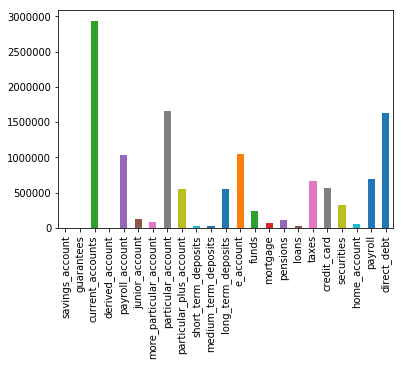

In [83]:
# sampled_classes = sampled_train_accounts.drop(["date", "cust_key"], axis=1)
sampled_y.sum().plot.bar()

### Resampling

Since the size of the data is huge, a random sample is used to train different models.

In [196]:
def resample_df(X_train_df, y_train_df, sampling_ratio):
    combined_train = pd.concat([X_train_df, y_train_df], axis=1)

    combined_train = combined_train.sample(frac=sampling_ratio, random_state=1)


    labels = list(y_train_df.columns)

    # remove "temp" when decided on a sampling ratio
    y_train_temp = combined_train[labels]
    X_train_temp = combined_train.drop(labels, axis=1)
    

    X_t, X_test, y_t, y_test = train_test_split(X_train_temp, y_train_temp, 
                                                test_size=0.30, random_state=42)
    return X_t, X_test, y_t, y_test

# Models

The following section contains different experiments with Logistic Regression and XGBoost. OneVsRestClassifier is a strategy which independently fits the model on each label, one by one.

## Experiment 1: Logistic Regression + Label Encoder

In [84]:
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), 
                                                        n_jobs=-1)),])

In [102]:
X_train, X_test, y_train, y_test = resample_df(X, y, sampling_ratio=0.1)

In [96]:
def logistic_regression(X_t, y_t, X_test, y_test):
    result_df = pd.DataFrame()
    for label in y_t.columns:
        print('**Processing {} label...**'.format(label))

        # Training logistic regression model on train data
        LogReg_pipeline.fit(X_t, y_t[label])

        # calculating test accuracy
        prediction = LogReg_pipeline.predict_proba(X_test)[:,1]
        result_df[label] = prediction
        print('Test average_precision_score is {}'.format(average_precision_score(y_test[label], prediction)))
        print("\n")
    return result_df

In [105]:
# sampling ratio 0.1
y_scores_ = logistic_regression(X_train, y_train, X_test, y_test)

## Experiment 2: Logistic Regression + Label Encoder + Normalization

In [106]:
from sklearn.preprocessing import StandardScaler

In [107]:
X_train_scale = X.copy()
X_train_scale.loc[:,:] = StandardScaler().fit_transform(X_train_scale)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [108]:
X_train_scale[:5]

,employee_index,country,sex,age,last_6_months_flag,seniority,primary,customer_type,customer_relation,domestic_index,foreigner_index,channel,deceased_status,province_code,activity_index,gross_income,segment
0,0.029725,-0.024099,-1.193723,-0.636722,-0.220107,-0.051900,-0.053481,0.175896,-0.879407,0.070974,-0.224303,1.229174,-0.060604,0.172389,0.916132,-0.249143,-0.187351
1,0.029725,-0.024099,-1.193723,-0.636722,-0.220107,-0.051900,-0.053481,0.175896,-0.879407,0.070974,-0.224303,1.229174,-0.060604,0.172389,0.916132,-0.249143,-0.187351
2,0.029725,-0.024099,-1.193723,-0.636722,-0.220107,-0.051900,-0.053481,0.175896,-0.879407,0.070974,-0.224303,1.229174,-0.060604,0.172389,0.916132,-0.249143,-0.187351
3,0.029725,-0.024099,0.837715,-1.350240,-0.220107,-0.033950,-0.053481,-1.035483,1.123574,0.070974,4.458258,1.174237,-0.060604,-1.156440,-1.091546,-0.480638,1.941231
4,0.029725,-0.024099,0.837715,-1.350240,-0.220107,-0.031146,-0.053481,0.175896,1.123574,0.070974,-0.224303,1.174237,-0.060604,-1.156440,-1.091546,-0.092506,1.941231


In [191]:
X_train, X_test, y_train, y_test = resample_df(X_train_scale, y, sampling_ratio=0.5)

In [112]:
# with 0.5 sampling ratio
y_scores_ = logistic_regression(X_train, y_train, X_test, y_test)

In [ ]:
# sampling ration 0.1
X_train, X_test, y_train, y_test = resample_df(X_train_scale, y, sampling_ratio=0.1)

In [216]:
y_scores = logistic_regression(X_train, y_train, X_test, y_test)

**Processing savings_account label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.0014457660890482534


**Processing guarantees label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.22404119435390515


**Processing current_accounts label...**
Test average_precision_score is 0.6461387175111962


**Processing derived_account label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.004297135674446141


**Processing payroll_account label...**
Test average_precision_score is 0.29846967750136777


**Processing junior_account label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.954664156102519


**Processing more_particular_account label...**
Test average_precision_score is 0.04918045635458529


**Processing particular_account label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.48025708926954147


**Processing particular_plus_account label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.14728403013495156


**Processing short_term_deposits label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.12986853740750906


**Processing medium_term_deposits label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.015331879610548023


**Processing long_term_deposits label...**
Test average_precision_score is 0.4382799532579761


**Processing e_account label...**
Test average_precision_score is 0.36645542808133375


**Processing funds label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.20544541051730178


**Processing mortgage label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.05426283502777952


**Processing pensions label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.11320277135446673


**Processing loans label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.06593564339668764


**Processing taxes label...**
Test average_precision_score is 0.24294126211748765


**Processing credit_card label...**
Test average_precision_score is 0.24772587519904626


**Processing securities label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.2253146035856351


**Processing home_account label...**


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test average_precision_score is 0.021727562383588032


**Processing payroll label...**
Test average_precision_score is 0.22505106907448935


**Processing direct_debt label...**
Test average_precision_score is 0.4717949999834879




In [218]:
# Average precision score for all classes:

average_precision_score(y_test, y_scores, average="micro")

0.4868983186700266

## Experiment 3: XGB + Label Encoder 

In [114]:
xgb_pipeline = Pipeline([('clf', OneVsRestClassifier(xgb.XGBClassifier(objective="binary:logistic", 
                                                                           random_state=42), n_jobs=-1)),])

In [182]:
def xgb_classifier(X_t, y_t, X_test, y_test, external_test_data=pd.DataFrame(), testing=False):
    result_df = pd.DataFrame()
    
    for category in y_t.columns:
        print('**Processing {} label...**'.format(category))

        # Training xgb model on train data
        xgb_pipeline.fit(X_t, y_t[category])

        # calculating test accuracy
        
        if testing:  
            prediction = xgb_pipeline.predict_proba(external_test_data)[:,1]
            result_df[category] = prediction
        
        prediction = xgb_pipeline.predict_proba(X_test)[:,1]

        print('Test average_precision_score is {}'.format(average_precision_score(y_test[category], prediction)))
        print("\n")
            
    return result_df

#### Testing for Sampling Ratio 0.1

In [202]:
X_train, X_test, y_train, y_test = resample_df(X, y, sampling_ratio=0.1)

(724888, 17)


In [203]:
X_train.shape

(507421, 17)

In [117]:
xgb_scores = xgb_classifier(X_train, y_train, X_test, y_test)

**Processing savings_account label...**
Test average_precision_score is 0.01092686131486573


**Processing guarantees label...**
Test average_precision_score is 0.027663537878927575


**Processing current_accounts label...**
Test average_precision_score is 0.6863414240783428


**Processing derived_account label...**
Test average_precision_score is 0.0030465699186928456


**Processing payroll_account label...**
Test average_precision_score is 0.4216178026051454


**Processing junior_account label...**
Test average_precision_score is 0.9915524920647871


**Processing more_particular_account label...**
Test average_precision_score is 0.31764614812720643


**Processing particular_account label...**
Test average_precision_score is 0.6444053528685815


**Processing particular_plus_account label...**
Test average_precision_score is 0.39506863179114327


**Processing short_term_deposits label...**
Test average_precision_score is 0.2937505522199767


**Processing medium_term_deposits label...**

In [118]:
# sampling ratio of 0.1
average_precision_score(y_test, xgb_scores, average="micro")

0.5585972924490238

#### Running for sampling ratio 0.5

In [204]:
X_train, X_test, y_train, y_test = resample_df(X, y, sampling_ratio=0.5)

(3624439, 17)


In [205]:
X_train.shape

(2537107, 17)

### Getting predictions for the Test Data (May, 2016)

In [198]:
def testing(test_df):
    ext_test = preprocess(test_df, testing=True)
    ext_test = ext_test.drop(['date', 'cust_id'], axis=1)
    fill_missing_values(ext_test, categorical_feats, numerical_feats)
    
    print(ext_test.shape)
    
    ext_test = encoder.transform(ext_test)
    return xgb_classifier(X_train, y_train, X_test, y_test, external_test_data=ext_test, testing=True)


In [199]:
monthly_predictions = testing(test_df)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(931453, 17)
**Processing savings_account label...**
Test average_precision_score is 0.01941423872976513


**Processing guarantees label...**
Test average_precision_score is 0.13291335468453822


**Processing current_accounts label...**
Test average_precision_score is 0.6860388056450235


**Processing derived_account label...**
Test average_precision_score is 0.004997607865875545


**Processing payroll_account label...**
Test average_precision_score is 0.41724918877287975


**Processing junior_account label...**
Test average_precision_score is 0.9916249056369185


**Processing more_particular_account label...**
Test average_precision_score is 0.3225274426357355


**Processing particular_account label...**
Test average_precision_score is 0.6446058518795131


**Processing particular_plus_account label...**
Test average_precision_score is 0.390628094389419


**Processing short_term_deposits label...**
Test average_precision_score is 0.278460466917486


**Processing medium_term_deposits la

In [206]:
monthly_predictions.shape

(931453, 23)

## Conclusion

Logistic regression performed better when it was given normalized data as opposed to when it was directly fed the raw dataframe. However, the performance of XGBoost was better than Logistic regression model. It also gave better results when trained on 50% of data as opposed to when it was trained with just 10%. So, with the right parameters and training done with more data, the model's performance would improve.

### Creating the submission file

In [207]:
def create_submission():
    col_row_tup = []
    sorted_tup = []
    cust_ids = list(test_df["cust_id"].values)
    
    for idx, val in monthly_predictions.iterrows():
        col_row_tup.append(zip(monthly_predictions.columns, val))
        
        
    for each in col_row_tup:
        sorted_tup.append(sorted(list(each), key=lambda x: x[1], reverse=True))

    submission_file = open('mehvish_predictions.csv', 'w')
    
    
    for idx, val in enumerate(sorted_tup):
        print(idx)
        submission_file.write(str(cust_ids[idx]) + "," + (";".join([x for x,v in val]))+'\n')


    submission_file.close()

In [209]:
create_submission()

# Future Work

If given more time and processing power, i would've liked to try the following experiments:
-  Try different sampling ratios for undersampling in order to deal with the class imbalance
-  Train the model with more data 
-  Implement cross validation and grid search for parameter tuning in XGBoost
-  Try a model which considers the dependence between output variables (Chain model) 
-  Try different ways of encoding categorical variables
-  Engineer additional features based on customer data e.g. divide the income in bins
-  Divide the code in different classes for data transformation, feature engineering and data modeling. 
